In [12]:
import numpy as np
from sklearn.linear_model import Lasso, LinearRegression
import random
from utils import extract_config_from_adj


n = 25
d = 4
b_min, b_max = 0.5, 2.0
sigma = 1.0
gamma = b_min**2 / 2
repeat = 10
node_grid = [5, 10, 20, 30, 40, 50]
SAMPLES_PER_TRIAL = 1000
REPS = repeat
thr = 0.5

def sample_d(lst, d):
    n = len(lst)
    if n == 0:
        return []
    parents = []
    probability = min(d / (n + 2), 1 / 2)
    for node in lst:
        if random.random() < probability:
            parents.append(node)
    return parents[:d]


def generate_config(n, d, b_min, b_max):
    """
    Sample a random Bayesian configuration of n vertices with <= d indegree
    """
    order = list(range(n))
    random.shuffle(order)
    coefficient = {i: {} for i in range(n)}
    parents = {i: set() for i in range(n)}
    B = [[0] * n for _ in range(n)]

    for i in range(n):
        node = order[i]
        # prt_sample = sample_d(order[:i], d)
        prt = sample_d(order[:i], d)
        parents[node] = set(prt.copy())
        for p in prt:
            abs_value = (b_min + (b_max - b_min) * random.random())
            sign = (2 * random.randint(0, 1) - 1)
            bij = abs_value * sign
            B[p][node] = coefficient[node][p] = bij

    return order, coefficient, parents, np.array(B)


def generate_sample(B, N):
    """
    From the sample configuration, sample a set of values.
    N is the number of samples, B is the coefficient matrix.
    """
    n = B.shape[0]
    raw = np.random.normal(0, 1, [N, n])
    return raw @ np.linalg.inv(np.eye(n) - B)


def combination(lst, d):
    """
    List all subsets (as list) with <= d elements in lst
    """
    if d == 0 or len(lst) == 0:
        return [[]]
    else:
        return combination(lst[1:], d) + [[lst[0]] + j for j in combination(lst[1:], d - 1)]


def choose(lst, d):
    """
    List all subsets (as list) with = d elements in lst
    """
    if d == 0:
        return [[]]
    elif d > len(lst):
        return []
    else:
        return choose(lst[1:], d) + [[lst[0]] + j for j in choose(lst[1:], d - 1)]


In [13]:
def lr(data, cand, index):
    '''
    Do OLS linear regression, given the data, candidate of nodes (cand) to
    regress on and the index of the node whom to regress on. Return the
    coefficient (if cand is not empty) and the MSE.
    '''
    assert index not in cand
    N = data.shape[0]
    Y = data[:, [index]]
    X = data[:, cand]

    coef = np.linalg.inv(X.T @ X) @ (X.T @ Y)
    mse = ((X @ coef - Y)**2).sum() / N
    return coef.T, mse


def topo(data, d):
    '''
    Find the topological order given the data and d. Return the topological
    order as a list of nodes.
    '''
    N, n = data.shape
    rem_nodes = list(range(n))
    top = [np.argmin(sum(data**2))]
    rem_nodes.remove(top[0])

    for _ in range(n - 2):
        best_mse = 1_000_000
        next_node = -1
        for r in rem_nodes:
            mse = 1_000_000
            for cand in combination(top, d):
                coef, mse1 = lr(data, cand, r)
                mse = min(mse, mse1)
            if mse < best_mse:
                best_mse = mse
                next_node = r
        rem_nodes.remove(next_node)
        top.append(next_node)

    top.append(rem_nodes[0])
    return top


def learning_parents_g(data, order, d):
    '''
    Using Gao et al. (2022)'s algorithm to find the parents given the
    topological order. Return the parents for each node as a dictionary.
    '''
    n = data.shape[1]
    parents = {i: set() for i in range(n)}

    for i in range(n):
        if i == 0:
            continue
        prev = order[:i]
        node = order[i]
        mse = 1_000_000
        parent_superset = None

        # Find C_j to be argmin(v_jc)
        for cand in combination(prev, d):
            coef, mse1 = lr(data, cand, node)
            if mse1 < mse:
                mse = mse1
                parent_superset = cand

        parent = set()
        for pa in parent_superset:
            parentm1 = parent_superset.copy()
            parentm1.remove(pa)

            coef, mse1 = lr(data, parentm1, node)
            if abs(mse-mse1) >= gamma:
                parent.add(pa)
        parents[node] = parent

    return parents


In [14]:

def lasso(data, cand, index):
    '''
    Run LASSO regression on given data.
    data: data matrix
    cand: candidate predictors
    index: target node index
    lambda_n: regularization parameter
    '''
    N = data.shape[0]
    Y = data[:, [index]]
    X = data[:, cand]
    X1 = data[:, cand]
    Y1 = data[:, [index]]
    lambda_n = 0.01

    if cand == []:
        return [], (Y**2).sum() / Y.size

    reg = Lasso(fit_intercept=False, alpha=lambda_n, copy_X=False).fit(X, Y)
    coef = reg.coef_
    mse = ((X @ np.array([coef]).T - Y) ** 2).sum() / N
    return coef, mse

In [15]:
def learning_parents_e(data, d):
    """
    Learn the parents by LASSO (efficient algorithm).
    Returns the topological order (top) and a dict of parents.
    Expects a global b_min and a function lasso(data, cand, index).
    """
    N, n = data.shape
    rem_nodes = list(range(n))
    top = [np.argmin(sum(data**2))]
    rem_nodes.remove(top[0])

    parents = {i: set() for i in range(n)}

    for _ in range(n - 1):
        best_node = -1
        best_mse = 1_000_000
        parent = set()

        for node in rem_nodes:
            coef, mse = lasso(data, top, node)
            if mse <= best_mse:
                best_mse = mse
                best_node = node
                # keep strong coefficients and cap at d parents
                parent = set(n for c, n in zip(coef, top) if abs(c) > b_min / 2)
                parent = set(list(parent)[:d])

        parents[best_node] = parent
        top.append(best_node)
        rem_nodes.remove(best_node)

    return top, parents

In [16]:
import numpy as np
from typing import Dict, Set, Any, Optional

def parents_dict_to_adj(
    parents: Dict[Any, Set[Any]],
    n: Optional[int] = None,
    dtype: type = float,
    check_bounds: bool = True
) -> np.ndarray:
    """
    Convert a mapping {child: {parent_i, ...}} to an adjacency matrix A
    with convention A[parent, child] = 1.

    Args:
        parents: dict mapping child -> set of parents (ints or np.integer).
        n: optional number of nodes; if None inferred from keys and parent entries.
        dtype: numpy dtype for the returned matrix (default float).
        check_bounds: if True, raises if any index is outside [0, n-1].

    Returns:
        A: (n x n) numpy array adjacency (binary 0/1).
    """
    # collect all node ids appearing as child or parent
    child_ids = list(parents.keys())
    parent_ids = [p for s in parents.values() for p in s]
    all_ids = set(int(x) for x in child_ids) | set(int(x) for x in parent_ids)

    if n is None:
        # infer n as max id + 1 (assumes nodes are 0..n-1)
        n = (max(all_ids) + 1) if all_ids else 0

    A = np.zeros((n, n), dtype=dtype)

    for child, prts in parents.items():
        c = int(child)
        if check_bounds and not (0 <= c < n):
            raise ValueError(f"Child index {c} out of bounds for n={n}.")
        for p in prts:
            pi = int(p)
            if check_bounds and not (0 <= pi < n):
                raise ValueError(f"Parent index {pi} out of bounds for n={n}.")
            A[pi, c] = 1

    return A


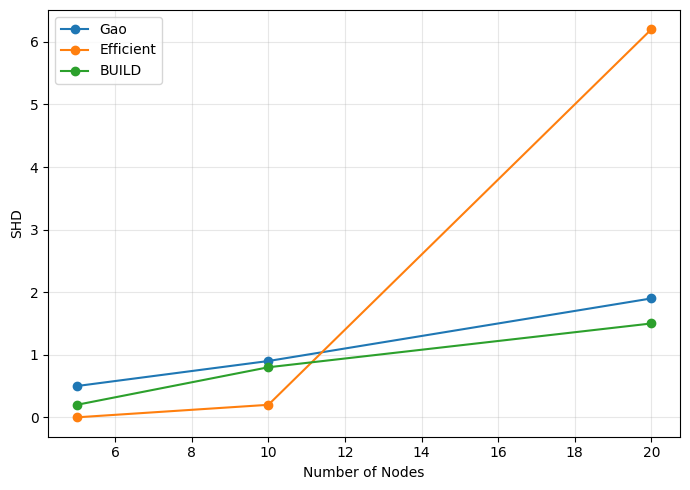

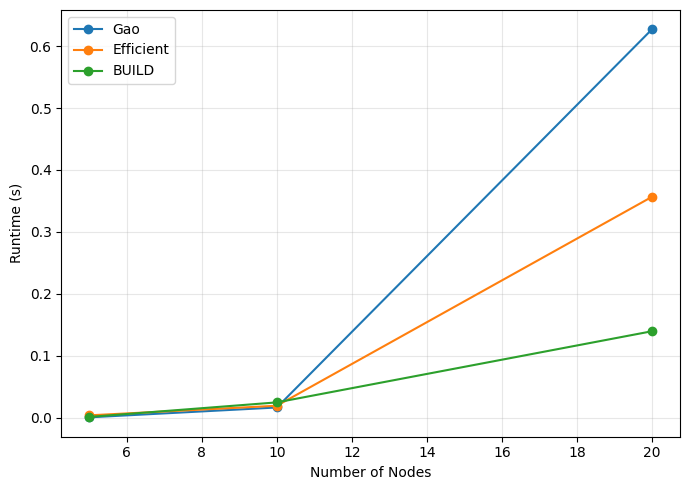

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from utils import count_accuracy
from BUILD import BUILD
import warnings
from utils import to_bin
warnings.filterwarnings("ignore")

d = 4       
b_min = 0.5
b_max = 2.0 
sigma = 1.0  
gamma = b_min**2 / 2   
repeat = 10 

node_grid = [5, 10, 20]
SAMPLES_PER_TRIAL = 1000      
REPS = repeat                 
thr = 0.5                    

# Storage
shd_gao_means, shd_eff_means, shd_topo_means = [], [], []
tim_gao_means, tim_eff_means, tim_topo_means = [], [], []

for n_nodes in node_grid:
    shd_gao_list, shd_eff_list, shd_topo_list = [], [], []
    tim_gao_list, tim_eff_list, tim_topo_list = [], [], []

    for j in range(REPS):
        # --- synthesize one DAG + data for this n_nodes ---
        order, coeff, true_parents, B = generate_config(n_nodes, d, b_min, b_max)
        X = np.array(generate_sample(B, SAMPLES_PER_TRIAL))
        emp_cov = np.cov(X, rowvar=False)

        # Ground-truth binary adjacency
        B_true_bin = to_bin(B, thr=thr)

        # --- Gao (needs topo order first) ---
        order_topo = topo(X, d)
        t0 = perf_counter()
        g_parents = learning_parents_g(X, order_topo, d)
        t1 = perf_counter()
        B_est_g = parents_dict_to_adj(g_parents)
        shd_gao_list.append(count_accuracy(B_true_bin, B_est_g)[0])
        tim_gao_list.append(t1 - t0)

        # --- Efficient ---
        t0 = perf_counter()
        e_parents = learning_parents_e(X, d)[1]
        t1 = perf_counter()
        B_est_e = parents_dict_to_adj(e_parents)
        shd_eff_list.append(count_accuracy(B_true_bin, B_est_e)[0])
        tim_eff_list.append(t1 - t0)

        # --- TopoGreedy (already returns binary A) ---
        t0 = perf_counter()
        topo_res = BUILD(
            X, emp_cov,
            k_list=[30], threshold_list=[1e-4],
            topo_thr=0.5, refresh_every=0.1
        )
        t1 = perf_counter()
        B_est_topo = topo_res['A_est_bin']
        shd_topo_list.append(count_accuracy(B_true_bin, B_est_topo)[0])
        tim_topo_list.append(t1 - t0)

    # Aggregate per n
    shd_gao_means.append(np.mean(shd_gao_list))
    shd_eff_means.append(np.mean(shd_eff_list))
    shd_topo_means.append(np.mean(shd_topo_list))

    tim_gao_means.append(np.mean(tim_gao_list))
    tim_eff_means.append(np.mean(tim_eff_list))
    tim_topo_means.append(np.mean(tim_topo_list))


import pandas as pd
import matplotlib.pyplot as plt

# Plot SHD results
plt.figure(figsize=(7,5))
plt.plot(node_grid, shd_gao_means, marker="o", label="Gao")
plt.plot(node_grid, shd_eff_means, marker="o", label="Efficient")
plt.plot(node_grid, shd_topo_means, marker="o", label="BUILD")
plt.xlabel("Number of Nodes")
plt.ylabel("SHD")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Runtime results
plt.figure(figsize=(7,5))
plt.plot(node_grid, tim_gao_means, marker="o", label="Gao")
plt.plot(node_grid, tim_eff_means, marker="o", label="Efficient")
plt.plot(node_grid, tim_topo_means, marker="o", label="BUILD")
plt.xlabel("Number of Nodes")
plt.ylabel("Runtime (s)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



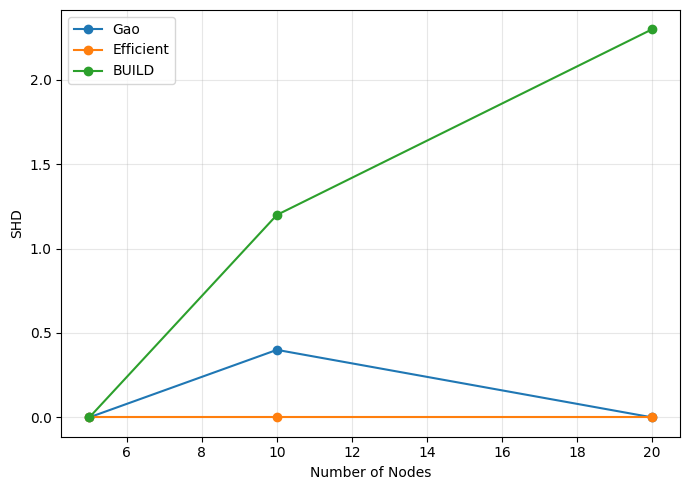

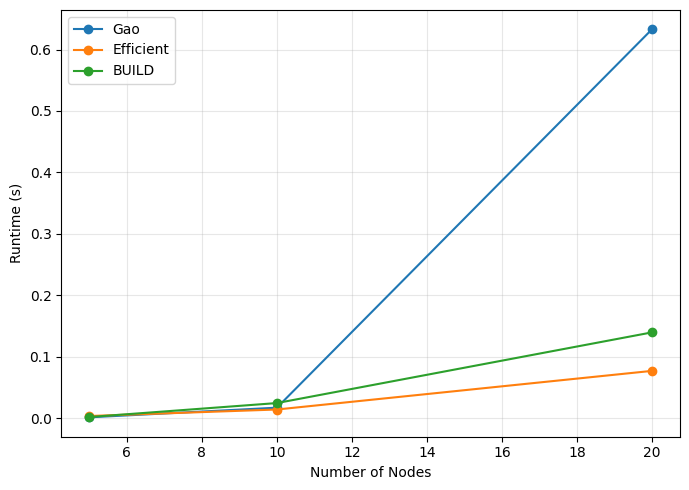

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from utils import count_accuracy
from BUILD import BUILD
import warnings
from utils import to_bin
warnings.filterwarnings("ignore")

d = 4       
b_min = 0.5
b_max = 1.0 
sigma = 1.0  
gamma = b_min**2 / 2   
repeat = 10 

node_grid = [5, 10, 20]
SAMPLES_PER_TRIAL = 1000      
REPS = repeat                 
thr = 0.5                    

# Storage
shd_gao_means, shd_eff_means, shd_topo_means = [], [], []
tim_gao_means, tim_eff_means, tim_topo_means = [], [], []

for n_nodes in node_grid:
    shd_gao_list, shd_eff_list, shd_topo_list = [], [], []
    tim_gao_list, tim_eff_list, tim_topo_list = [], [], []

    for j in range(REPS):
        # --- synthesize one DAG + data for this n_nodes ---
        order, coeff, true_parents, B = generate_config(n_nodes, d, b_min, b_max)
        X = np.array(generate_sample(B, SAMPLES_PER_TRIAL))
        emp_cov = np.cov(X, rowvar=False)

        # Ground-truth binary adjacency
        B_true_bin = to_bin(B, thr=thr)

        # --- Gao (needs topo order first) ---
        order_topo = topo(X, d)
        t0 = perf_counter()
        g_parents = learning_parents_g(X, order_topo, d)
        t1 = perf_counter()
        B_est_g = parents_dict_to_adj(g_parents)
        shd_gao_list.append(count_accuracy(B_true_bin, B_est_g)[0])
        tim_gao_list.append(t1 - t0)

        # --- Efficient ---
        t0 = perf_counter()
        e_parents = learning_parents_e(X, d)[1]
        t1 = perf_counter()
        B_est_e = parents_dict_to_adj(e_parents)
        shd_eff_list.append(count_accuracy(B_true_bin, B_est_e)[0])
        tim_eff_list.append(t1 - t0)

        # --- TopoGreedy (already returns binary A) ---
        t0 = perf_counter()
        topo_res = BUILD(
            X, emp_cov,
            k_list=[30], threshold_list=[1e-4],
            topo_thr=0.5, refresh_every=0.1
        )
        t1 = perf_counter()
        B_est_topo = topo_res['A_est_bin']
        shd_topo_list.append(count_accuracy(B_true_bin, B_est_topo)[0])
        tim_topo_list.append(t1 - t0)
    # Aggregate per n
    shd_gao_means.append(np.mean(shd_gao_list))
    shd_eff_means.append(np.mean(shd_eff_list))
    shd_topo_means.append(np.mean(shd_topo_list))

    tim_gao_means.append(np.mean(tim_gao_list))
    tim_eff_means.append(np.mean(tim_eff_list))
    tim_topo_means.append(np.mean(tim_topo_list))

# Plot SHD results
plt.figure(figsize=(7,5))
plt.plot(node_grid, shd_gao_means, marker="o", label="Gao")
plt.plot(node_grid, shd_eff_means, marker="o", label="Efficient")
plt.plot(node_grid, shd_topo_means, marker="o", label="BUILD")
plt.xlabel("Number of Nodes")
plt.ylabel("SHD")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Runtime results
plt.figure(figsize=(7,5))
plt.plot(node_grid, tim_gao_means, marker="o", label="Gao")
plt.plot(node_grid, tim_eff_means, marker="o", label="Efficient")
plt.plot(node_grid, tim_topo_means, marker="o", label="BUILD")
plt.xlabel("Number of Nodes")
plt.ylabel("Runtime (s)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

